# Load email data & preprocess

In [1]:
from datasets import Dataset, DatasetDict, ClassLabel, Value
import pandas as pd

df = pd.read_csv("extracted_emails.csv")
df = pd.DataFrame(df)

dataset = Dataset.from_pandas(df)
print(dataset)

Dataset({
    features: ['id', 'label', 'subject', 'text'],
    num_rows: 6366
})


In [2]:
null_counts = dataset.to_pandas().isnull().sum()
print(null_counts)

id          0
label       0
subject    25
text       41
dtype: int64


In [3]:
null_rows = dataset.to_pandas()[dataset.to_pandas().isnull().any(axis=1)]
print(null_rows)

                    id                    label  \
36    196ee752113d4a0a                     Ayra   
632   19494a027ba73bf6      Job Search/Rejected   
705   194426617ce21d08      Job Search/Rejected   
855   193b7d4b37e70d05      Job Search/Rejected   
895   1938d0a0ecb202f8      Job Search/Rejected   
990   19341116a9699e8f  Work/Study & Coursework   
1061  192f4e858a3455e0  Work/Study & Coursework   
1117  192a7e76d5c6d883                     DOCS   
1119  192a7c53d394718e                     DOCS   
1120  192a6e5522af4f3b                     DOCS   
1190  1926ca818314fea1                     Ayra   
1322  1921ca0037668c35                     DOCS   
1387  191dc2352edc262a                   Marium   
1388  191dc1386ba5a7db                   Marium   
1695  191037ad87c8bd6b         Bookings/Flights   
1923  19082d966f52a0d0                    Ameen   
1927  19082adc570ae67f                    Ameen   
2469  18eeb61b8badcb94                     DOCS   
3007  18d91e8b519ee991  Work/St

In [4]:
# define class label

new_features = dataset.features.copy()
new_features["label"] = ClassLabel(names_file="names.txt")
dataset = dataset.cast(new_features)
dataset.features

# behind the scenes: class label is int, so no need to preprocess the feature 'label' in this dataset.
# the mapping of integers to label name is stored in the names.txt file

Casting the dataset:   0%|          | 0/6366 [00:00<?, ? examples/s]

{'id': Value(dtype='string', id=None),
 'label': ClassLabel(names=['Investments/Al Meezan', 'Transactions/Receipts', 'Transactions/Bills due', 'Job Search/Applied', 'Work/Study & Coursework', 'Admissions', 'Papa', 'Home/Insurance', 'Security & Verification/Codes & Links', 'DOCS', 'Bank Accounts/RBC', 'Security & Verification/Action Required', 'Bookings/Flights', 'Newsletters & Promos', 'Work/SURE', 'Bank Accounts/Wise', 'Shopping', 'Phone & Wifi/Fido', 'Ameen', 'Work/Developer', 'Bookings/Transport', 'Security & Verification/Account activity', 'Marium', 'Events & Tickets', 'Job Search/Leads', 'Support & Feedback', 'Bank Accounts/Meezan', 'Home/Opus 6', 'Appointments', 'Work/Freelance', 'Bookings/Communauto', 'Healthcare', 'Job Search/Next steps', 'Investments/WealthSimple', 'Phone & Wifi/Fizz', 'Job Search/Rejected', 'Bank Accounts/TD', 'Government', 'Bookings/Hotel', 'Ayra', 'Bank Accounts/Scotia', 'apt search'], id=None),
 'subject': Value(dtype='string', id=None),
 'text': Value(dty

In [5]:
from sklearn.model_selection import train_test_split
import pandas as pd
from datasets import Dataset, DatasetDict

# Convert to pandas for stratified splitting
df = dataset.to_pandas()

# Step 1: Train/Val+Test Split (stratify on 'label')
train_val_df, test_df = train_test_split(
    df, test_size=0.1, stratify=df['label'], random_state=42
)

# Step 2: Train/Val Split (again, stratify)
train_df, val_df = train_test_split(
    train_val_df, test_size=0.1, stratify=train_val_df['label'], random_state=42
)

# Convert back to Hugging Face Datasets
train_dataset = Dataset.from_pandas(train_df)
val_dataset = Dataset.from_pandas(val_df)
test_dataset = Dataset.from_pandas(test_df)

# Final DatasetDict
final_splits = DatasetDict({
    "train": train_dataset,
    "validation": val_dataset,
    "test": test_dataset
})

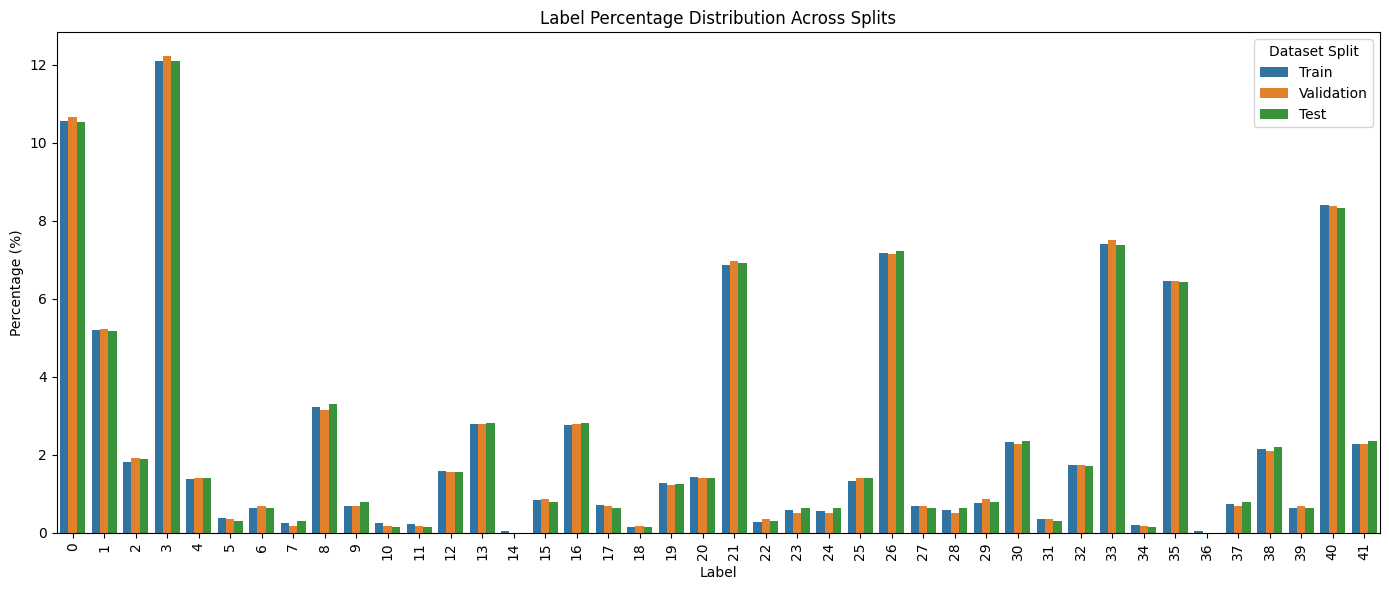

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_label_distribution(df, title):
    plt.figure(figsize=(12, 5))
    sns.countplot(x='label', data=df, order=sorted(df['label'].unique()))
    plt.title(title)
    plt.xlabel("Label")
    plt.ylabel("Count")
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()

def plot_label_percentage_distribution(df, title):
    label_counts = df['label'].value_counts(normalize=True).sort_index() * 100
    plt.figure(figsize=(12, 5))
    sns.barplot(x=label_counts.index, y=label_counts.values)
    plt.title(title)
    plt.xlabel("Label")
    plt.ylabel("Percentage (%)")
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()


def get_label_percentages(df, split_name):
    percentages = df['label'].value_counts(normalize=True).sort_index() * 100
    return pd.DataFrame({
        'Label': percentages.index,
        'Percentage': percentages.values,
        'Split': split_name
    })

# Combine all splits into one DataFrame
df_all = pd.concat([
    get_label_percentages(train_df, 'Train'),
    get_label_percentages(val_df, 'Validation'),
    get_label_percentages(test_df, 'Test')
])

# Plot
plt.figure(figsize=(14, 6))
sns.barplot(data=df_all, x='Label', y='Percentage', hue='Split')
plt.title("Label Percentage Distribution Across Splits")
plt.xlabel("Label")
plt.ylabel("Percentage (%)")
plt.xticks(rotation=90)
plt.legend(title='Dataset Split')
plt.tight_layout()
plt.show()


In [8]:
# define tokenization logic
# This function takes a dictionary (like the items of our dataset) and returns
# a new dictionary with the keys input_ids, attention_mask, and token_type_ids

def safe_str(x):
    if x is None:
        return ""
    return str(x)

def tokenize_function(examples):
    subjects = [safe_str(s) for s in examples["subject"]]
    texts = [safe_str(t) for t in examples["text"]]
    return tokenizer(subjects, texts, truncation=True)

In [9]:
from transformers import AutoTokenizer, DataCollatorWithPadding

checkpoint = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

# Tokenize the dataset
tokenized_datasets = final_splits.map(tokenize_function, batched=True)
print(tokenized_datasets)

# Our tokenize_function returns a dictionary with the keys input_ids, attention_mask,
# and token_type_ids, so those three fields are added to all splits of our dataset.

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Map:   0%|          | 0/5156 [00:00<?, ? examples/s]

Map:   0%|          | 0/573 [00:00<?, ? examples/s]

Map:   0%|          | 0/637 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['id', 'label', 'subject', 'text', '__index_level_0__', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 5156
    })
    validation: Dataset({
        features: ['id', 'label', 'subject', 'text', '__index_level_0__', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 573
    })
    test: Dataset({
        features: ['id', 'label', 'subject', 'text', '__index_level_0__', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 637
    })
})


In [10]:
# test sample batch
# Remove the columns id, subject, and text as they won’t be needed and contain strings (and we can’t create tensors with strings)
samples = tokenized_datasets["train"].select(range(8))
samples = [{k: v for k, v in sample.items() if k in ["input_ids", "attention_mask", "token_type_ids", "label"]} for sample in samples]

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)
batch = data_collator(samples)
print({k: v.shape for k, v in batch.items()})

{'input_ids': torch.Size([8, 512]), 'token_type_ids': torch.Size([8, 512]), 'attention_mask': torch.Size([8, 512]), 'labels': torch.Size([8])}


Now that we’ve gone from raw text to batches our model can deal with, we’re ready to fine-tune it!

# Fine-tune

In [ ]:
# The first step before we can define our Trainer is to define a TrainingArguments class that will contain all the hyperparameters
# the Trainer will use for training and evaluation. The only argument you have to provide is a directory where the
# trained model will be saved, as well as the checkpoints along the way. For all the rest, you can leave the defaults,
# which should work pretty well for a basic fine-tuning.

# from transformers import TrainingArguments

# training_args = TrainingArguments("test-trainer4")

In [11]:
# The second step is to define our model. As in the previous chapter, we will use the
# AutoModelForSequenceClassification class, with two labels:

from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=42)

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [12]:
label_values = tokenized_datasets["train"]["label"]
print("Unique label values:", sorted(set(label_values)))
print("Label value range:", min(label_values), "to", max(label_values))

Unique label values: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41]
Label value range: 0 to 41


This will start the fine-tuning (which should take a couple of minutes on a GPU) and report the training loss every 500 steps. It won’t, however, tell you how well (or badly) your model is performing. This is because:

We didn’t tell the Trainer to evaluate during training by setting eval_strategy in TrainingArguments to either "steps" (evaluate every eval_steps) or "epoch" (evaluate at the end of each epoch).
We didn’t provide the Trainer with a compute_metrics() function to calculate a metric during said evaluation (otherwise the evaluation would just have printed the loss, which is not a very intuitive number).

In [13]:
from transformers import Trainer, TrainingArguments, EarlyStoppingCallback
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

def compute_metrics(p):
    preds = p.predictions.argmax(-1)
    labels = p.label_ids
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc}


# Define training arguments
training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=10,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",  # Change to "eval_loss" if preferred
    greater_is_better=True,            # Set to False if using loss
    logging_dir="./logs",
    logging_strategy="epoch",
    report_to="wandb"  # Enable default logging (e.g., to WandB)
)

# Initialize the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    processing_class=tokenizer,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
)

In [14]:
trainer.train()
# trainer.train(resume_from_checkpoint=True)

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: musabumair005 (musabumair0191) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss,Accuracy
1,1.646300,0.843341,0.815009
2,0.546900,0.466310,0.886562
3,0.264900,0.326408,0.923211
4,0.129700,0.336191,0.921466
5,0.077600,0.356791,0.931937
6,0.050600,0.316089,0.940663
7,0.039100,0.373930,0.926702
8,0.029400,0.342161,0.938918


TrainOutput(global_step=5160, training_loss=0.3480611753094104, metrics={'train_runtime': 4479.6651, 'train_samples_per_second': 11.51, 'train_steps_per_second': 1.44, 'total_flos': 1.082400129639576e+16, 'train_loss': 0.3480611753094104, 'epoch': 8.0})

In [15]:
# Evaluate
test_results = trainer.evaluate(eval_dataset=tokenized_datasets["test"])
print(f"Test Accuracy: {test_results['eval_accuracy']:.4f}")

Test Accuracy: 0.9309
